Purpose: Show why wlasso would fail; Make logistic regression fail

In [96]:
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2
from lib.utility import show_tensor_image, show_acc, to_var
from lib.model import MLP
from lib.openbox import open_box, count_config, find_x
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.train import prepareData
from lib.utility import show_tensor_image, show_acc, to_var

In [99]:
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

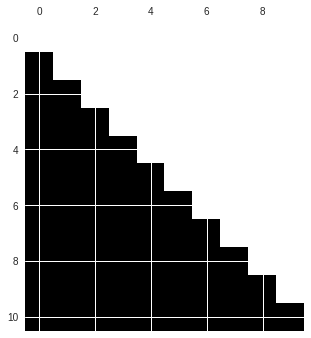

In [123]:
from lib.synthetic_data_generation import generate_risk, genCovData
from scipy.linalg import block_diag

def sweepR(t=1,mu=0,noise=0.05):
    '''t: theta coefficient'''
    nrgroups = 11
    nirgroups = 0
    pergroup = 10
    n = 5000
    # setup
    risk = generate_risk(nrgroups, nirgroups, pergroup, "binary_r")
    # gen data
    base = np.diag(np.ones(pergroup))       
    base[base==0] = 0.99
    C = block_diag(*([base]*(nrgroups+nirgroups)))
    theta = np.zeros((nrgroups + nirgroups) * pergroup)
    theta[:nrgroups*pergroup] = t
    datagen = lambda: genCovData(C=C, theta=theta,
                                 n=n, noise=noise, mu=mu)    
    return datagen, risk

d, risk = sweepR(t=-1, mu=10)
X, y = d()
plt.matshow(risk.reshape(-1, 10))
plt.show()

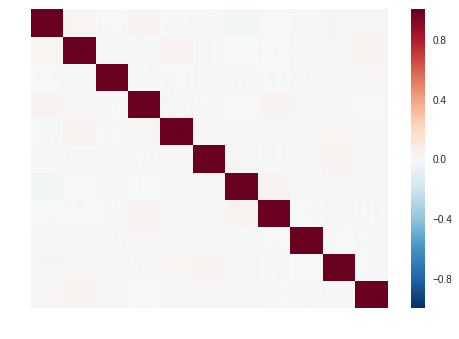

In [124]:
sns.heatmap(np.corrcoef(X.T))
plt.axis('off')
plt.show()

In [125]:
d1, risk = sweepR(t=-1, mu=0)
d2, risk = sweepR(t=1, mu=10)

X1, y1 = d1()
X2, y2 = d2()

Xtr = np.vstack([X1, X2])
ytr = np.vstack([y1, y2])

X1, y1 = d1()
X2, y2 = d2()

Xte = np.vstack([X1, X2])
yte = np.vstack([y1, y2])

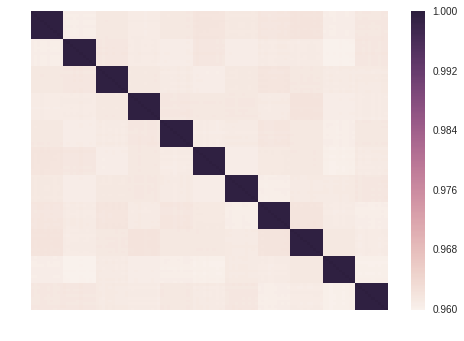

In [126]:
# todo: break correlation (X1 and X2 have different correlation structure)
sns.heatmap(np.corrcoef(Xtr.T))
plt.axis('off')
plt.show()

In [131]:
net = MLP(neuron_sizes=[110, 8, 2])

train_data = TensorDataset(*map(lambda x: x.data, prepareData(Xtr, ytr.reshape(-1))))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)   

test_data = TensorDataset(*map(lambda x: x.data, prepareData(Xte, yte.reshape(-1))))
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)   

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

train(net, train_loader, criterion, optimizer, print_every=30, epochs=10, max_time=50)

[1,    30] loss: 0.7392165105
[1,    60] loss: 0.6992872596
[1,    90] loss: 0.6744634847
[1,   120] loss: 0.6667796115
[1,   150] loss: 0.6362423023
[2,    30] loss: 0.6320373277
[2,    60] loss: 0.6177771091
[2,    90] loss: 0.5779317518
[2,   120] loss: 0.5952044110
[2,   150] loss: 0.5726867169
[3,    30] loss: 0.5836629808
[3,    60] loss: 0.5616965850
[3,    90] loss: 0.5724281391
[3,   120] loss: 0.5566571107
[3,   150] loss: 0.5555843433
[4,    30] loss: 0.5449420581
[4,    60] loss: 0.5282669723
[4,    90] loss: 0.5703434368
[4,   120] loss: 0.5517750283
[4,   150] loss: 0.5458979915
[5,    30] loss: 0.5315464675
[5,    60] loss: 0.5494694193
[5,    90] loss: 0.5306569427
[5,   120] loss: 0.5319370925
[5,   150] loss: 0.5186364690
[6,    30] loss: 0.5377309342
[6,    60] loss: 0.5433174958
[6,    90] loss: 0.4970604459
[6,   120] loss: 0.5368837963
[6,   150] loss: 0.5015791237
[7,    30] loss: 0.5286358168
[7,    60] loss: 0.5019669056
[7,    90] loss: 0.5099432230
[7,   120]

In [132]:
show_acc(net, test_loader)

Accuracy of the network on 10000  images: 73 %
